In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import peakutils as pkuts
from scipy import fftpack
from scipy.interpolate import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox
import datetime as datetime
from datetime import datetime, timedelta
import os
import ctypes
import imufusion
import sys

C:\Users\tongx\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [143]:
file1 = '10122023_both_alterONOFF1min_104Hz_1.txt'

In [144]:
header = 0

dat1 = pd.read_csv(file1, header = header, dtype = str, delimiter = '|', names = ['Time','MISC','Packet','Message','RSSI'])
dat1 = dat1[~dat1.RSSI.str.contains('error')]
dat1 = dat1[dat1.MISC.str.contains('f|e|6')] # To keep voltage, temperature and motility data only
dat1 = dat1.reset_index(drop=True)
dat1_col = dat1.Message
dat1_col = dat1_col.str.strip()
hexdat1 = dat1_col.str.split(' ')

In [145]:
dat2 = dat1[dat1.MISC == ' 0f '] # background
dat3 = dat1[dat1.MISC == ' 0e ']

In [146]:
#dat2 = dat1_short[dat1_short.MISC == ' 0f '] # background
#dat3 = dat1_short[dat1_short.MISC == ' 0e ']

In [147]:
dat2 = dat2.reset_index(drop=True)
dat2_col = dat2.Message
dat2_col = dat2_col.str.strip()
hexdat2 = dat2_col.str.split(' ')

for i in range(0, len(hexdat2)):
    hexdat2[i] = hexdat2[i][1:13]

In [148]:
dat3 = dat3.reset_index(drop=True)
dat3_col = dat3.Message
dat3_col = dat3_col.str.strip()
hexdat3 = dat3_col.str.split(' ')

In [149]:
dat2 = dat2.assign(Temperature = np.nan, Voltage = np.nan)
dat3 = dat3.assign(Temperature = np.nan, Voltage = np.nan)

In [150]:
XL_scale_range_2g = 0.061
XL_scale_range_4g = 0.122
G_scale_range_1000dps = 35
G_scale_range_2000dps = 70

for k, ele in enumerate(hexdat3): # k: count; ele: item
        if len(ele) == 12: # Only select those that have the correct length
            vlist=[]
            for i in range(0, 6):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i <= 2:
                    vlist.append(round(float(convert_value)*XL_scale_range_4g/1000, 2))
                else:
                    vlist.append(round(float(convert_value)*G_scale_range_1000dps/1000, 2))
                    
            dat3.Message[k] = vlist
            
        elif len(ele) == 4:
            dat3.Message[k] = 'NaN'
            for i in range(0, 2):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i == 0:
                 #   vlist.append(float((convert_value/1000)))
                    dat3.Voltage[k] = float((convert_value/1000))
                else:
                  #  vlist.append(float(convert_value))
                    dat3.Temperature[k] = float(convert_value)
        
        else:
            #print('Line Error!'+str(k))
            #print(ele)
            vlist = [] #add empty list on error

<ipython-input-150-fd42d8c0403a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat3.Message[k] = vlist


In [151]:
 # get only the filename from the file path
_, filename1 = os.path.split(file1)
date1 = filename1.split('_')[0]
date1 = datetime.strptime(date1, '%m%d%Y') #which takes in "MMDDYYYY" like only US people write date order
 # Convert "realtime" to datetime, adding the date
dat3["Time"] = dat3["Time"].str.strip()
dat3["Time"] = pd.to_datetime(dat3["Time"], format='%H:%M:%S.%f')
dat3["Time"] = dat3["Time"].apply(lambda t: datetime.combine(date1, t.time()))
# Check for date rollover and increment the date when necessary
dat3["Time"] = dat3["Time"].mask(dat3["Time"].diff().dt.total_seconds() < 0, 
                                           dat3["Time"] + timedelta(days=1))

In [152]:
dat3

,Time,MISC,Packet,Message,RSSI,Temperature,Voltage
0,2023-10-12 12:01:00.792,0e,52069,"[0.65, -0.35, -0.83, -14.38, -39.94, 2.69]",-67,NaN,NaN
1,2023-10-12 12:01:00.792,0e,52070,"[0.49, -0.65, -0.66, 64.92, -42.0, 13.37]",-67,NaN,NaN
2,2023-10-12 12:01:00.792,0e,52071,"[0.37, -0.66, -0.68, 13.05, -43.37, 7.35]",-67,NaN,NaN
3,2023-10-12 12:01:00.792,0e,52072,"[0.36, -0.54, -0.84, 5.11, -54.11, 10.71]",-67,NaN,NaN
4,2023-10-12 12:01:00.793,0e,52073,"[0.08, -0.78, -0.7, 53.97, -54.35, 20.72]",-67,NaN,NaN
...,...,...,...,...,...,...,...
29056,2023-10-12 12:06:00.870,0e,18373,"[-0.35, 0.28, -1.02, -13.72, 49.95, -10.54]",-68,NaN,NaN
29057,2023-10-12 12:06:00.870,0e,18374,"[-0.14, 0.32, -0.94, 1.08, 56.0, -7.42]",-67,NaN,NaN
29058,2023-10-12 12:06:00.870,0e,18375,"[-0.03, 0.45, -0.92, -11.41, 56.24, -7.74]",-67,NaN,NaN
29059,2023-10-12 12:06:00.870,0e,18376,"[-0.01, 0.53, -0.92, -6.3, 62.05, -6.54]",-67,NaN,NaN


In [153]:
for k, ele in enumerate(hexdat2): # k: count; ele: item
        if len(ele) == 12: # Only select those that have the correct length
            vlist=[]
            for i in range(0, 6):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i <= 2:
                    vlist.append(round(float(convert_value)*XL_scale_range_4g/1000, 2))
                else:
                    vlist.append(round(float(convert_value)*G_scale_range_1000dps/1000, 2))
                    
            dat2.Message[k] = vlist
            
        elif len(ele) == 4:
            dat2.Message[k] = 'NaN'
            for i in range(0, 2):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i == 0:
                 #   vlist.append(float((convert_value/1000)))
                    dat2.Voltage[k] = float((convert_value/1000))
                else:
                  #  vlist.append(float(convert_value))
                    dat2.Temperature[k] = float(convert_value)
        
        else:
            #print('Line Error!'+str(k))
            #print(ele)
            vlist = [] #add empty list on error

<ipython-input-153-c1804853ede3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2.Message[k] = vlist


In [154]:
 # get only the filename from the file path
_, filename1 = os.path.split(file1)
date1 = filename1.split('_')[0]
date1 = datetime.strptime(date1, '%m%d%Y') #which takes in "MMDDYYYY" like only US people write date order
 # Convert "realtime" to datetime, adding the date
dat2["Time"] =  dat2["Time"].str.strip()
dat2["Time"] = pd.to_datetime(dat2["Time"], format='%H:%M:%S.%f')
dat2["Time"] = dat2["Time"].apply(lambda t: datetime.combine(date1, t.time()))
# Check for date rollover and increment the date when necessary
dat2["Time"] = dat2["Time"].mask(dat2["Time"].diff().dt.total_seconds() < 0, 
                                           dat2["Time"] + timedelta(days=1))

In [155]:
dat3[['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = np.nan
dat2[['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = np.nan

In [156]:
dat3.loc[dat3.Message != 'NaN', ['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = dat3[dat3.Message != 'NaN'].Message.tolist()
dat2.loc[dat2.Message != 'NaN', ['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = dat2[dat2.Message != 'NaN'].Message.tolist()

In [157]:
dat2

,Time,MISC,Packet,Message,RSSI,Temperature,Voltage,XL_X,XL_Y,XL_Z,G_X,G_Y,G_Z
0,2023-10-12 12:01:00.792,0f,53151,"[0.19, -0.21, -0.93, 0.53, 1.57, 0.53]",-62,NaN,NaN,0.19,-0.21,-0.93,0.53,1.57,0.53
1,2023-10-12 12:01:00.792,0f,53152,"[0.16, -0.18, -1.03, 0.07, 0.32, -0.04]",-62,NaN,NaN,0.16,-0.18,-1.03,0.07,0.32,-0.04
2,2023-10-12 12:01:00.792,0f,53153,"[0.06, -0.32, -0.94, 0.67, 0.0, 2.1]",-62,NaN,NaN,0.06,-0.32,-0.94,0.67,0.00,2.10
3,2023-10-12 12:01:00.793,0f,53154,"[-0.07, -0.31, -1.0, 0.81, -0.84, 2.9]",-62,NaN,NaN,-0.07,-0.31,-1.00,0.81,-0.84,2.90
4,2023-10-12 12:01:00.793,0f,53155,"[-0.13, -0.25, -1.0, 0.04, -1.44, 0.88]",-62,NaN,NaN,-0.13,-0.25,-1.00,0.04,-1.44,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30289,2023-10-12 12:06:00.870,0f,19658,"[-0.31, -0.09, -1.0, -0.1, -3.15, 1.01]",-64,NaN,NaN,-0.31,-0.09,-1.00,-0.10,-3.15,1.01
30290,2023-10-12 12:06:00.870,0f,19659,"[-0.28, 0.03, -0.94, -0.7, 0.49, -0.1]",-64,NaN,NaN,-0.28,0.03,-0.94,-0.70,0.49,-0.10
30291,2023-10-12 12:06:00.870,0f,19660,"[-0.24, 0.11, -1.02, -0.21, -0.24, -1.44]",-64,NaN,NaN,-0.24,0.11,-1.02,-0.21,-0.24,-1.44
30292,2023-10-12 12:06:00.870,0f,19661,"[-0.14, 0.19, -0.99, -0.59, 0.21, -2.24]",-64,NaN,NaN,-0.14,0.19,-0.99,-0.59,0.21,-2.24


In [158]:
dat3["Packet"] = dat3["Packet"].astype(int)
dat2["Packet"] = dat2["Packet"].astype(int)

In [159]:
start_time2 = dat2["Time"].iloc[0]
tarray2 = pd.array((dat2["Time"] - start_time2).dt.total_seconds())
tseries2 = pd.Series(tarray2, name = 'Timestamp')
dat2 = pd.concat((dat2, tseries2), axis=1)

In [160]:
start_time3 = dat3["Time"].iloc[0]
tarray3 = pd.array((dat3["Time"] - start_time3).dt.total_seconds())
tseries3 = pd.Series(tarray3, name = 'Timestamp')
dat3 = pd.concat((dat3, tseries3), axis=1)

In [161]:
#dat2.to_csv('first_part_dat2.csv')
#dat3.to_csv('first_part_dat3.csv') 

In [162]:
#dat2 = pd.read_csv('First_dat2.csv')  
#dat3 = pd.read_csv('First_dat3.csv')  

In [163]:
dat2_ave_final = dat2
dat3_ave_final = dat3

In [164]:
dat2_ave_final["G_X_dps"] = dat2_ave_final["G_X"]/1000
dat2_ave_final["G_Y_dps"] = dat2_ave_final["G_Y"]/1000
dat2_ave_final["G_Z_dps"] = dat2_ave_final["G_Z"]/1000

In [165]:
dat3_ave_final["G_X_dps"] = dat3_ave_final["G_X"]/1000
dat3_ave_final["G_Y_dps"] = dat3_ave_final["G_Y"]/1000
dat3_ave_final["G_Z_dps"] = dat3_ave_final["G_Z"]/1000

In [166]:
dat2_ave_final = dat2_ave_final[['Timestamp','XL_X', 'XL_Y','XL_Z','G_X_dps','G_Y_dps','G_Z_dps']] 
dat3_ave_final = dat3_ave_final[['Timestamp','XL_X', 'XL_Y','XL_Z','G_X_dps','G_Y_dps','G_Z_dps',]]

In [167]:
dat2_array = dat2_ave_final.to_numpy()
dat3_array = dat3_ave_final.to_numpy()

In [168]:
accel2 = dat2_array[:, 1:4]
gyro2 = dat2_array[:, 4:7]

accel3 = dat3_array[:, 1:4]
gyro3 = dat3_array[:, 4:7]

In [169]:
# Process sensor data
ahrs2 = imufusion.Ahrs()
euler2 = np.empty((len(dat2_ave_final["Timestamp"]), 3))

for index in range(len(dat2_ave_final["Timestamp"])):
    ahrs2.update_no_magnetometer(gyro2[index], accel2[index], 1 / 104)  # 104 Hz sample rate
    euler2[index] = ahrs2.quaternion.to_euler()

In [170]:
# Process sensor data
ahrs3 = imufusion.Ahrs()
euler3 = np.empty((len(dat3_ave_final["Timestamp"]), 3))

for index in range(len(dat3_ave_final["Timestamp"])):
    ahrs3.update_no_magnetometer(gyro3[index], accel3[index], 1 / 104)  # 104 Hz sample rate
    euler3[index] = ahrs3.quaternion.to_euler()

In [171]:
dat2_ave_final['roll'] = np.unwrap(euler2[:,0], discont=30).tolist()
dat2_ave_final['pitch'] = np.unwrap(euler2[:,1], discont=30).tolist()
dat2_ave_final['yaw'] = np.unwrap(euler2[:,2], discont=30).tolist()

<ipython-input-171-d1e31c7ac04b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2_ave_final['roll'] = np.unwrap(euler2[:,0], discont=30).tolist()
<ipython-input-171-d1e31c7ac04b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2_ave_final['pitch'] = np.unwrap(euler2[:,1], discont=30).tolist()
<ipython-input-171-d1e31c7ac04b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [172]:
dat3_ave_final['roll'] = np.unwrap(euler3[:,0], discont=30).tolist()
dat3_ave_final['pitch'] = np.unwrap(euler3[:,1], discont=30).tolist()
dat3_ave_final['yaw'] = np.unwrap(euler3[:,2], discont=30).tolist()

<ipython-input-172-4b04488f5ded>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat3_ave_final['roll'] = np.unwrap(euler3[:,0], discont=30).tolist()
<ipython-input-172-4b04488f5ded>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat3_ave_final['pitch'] = np.unwrap(euler3[:,1], discont=30).tolist()
<ipython-input-172-4b04488f5ded>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

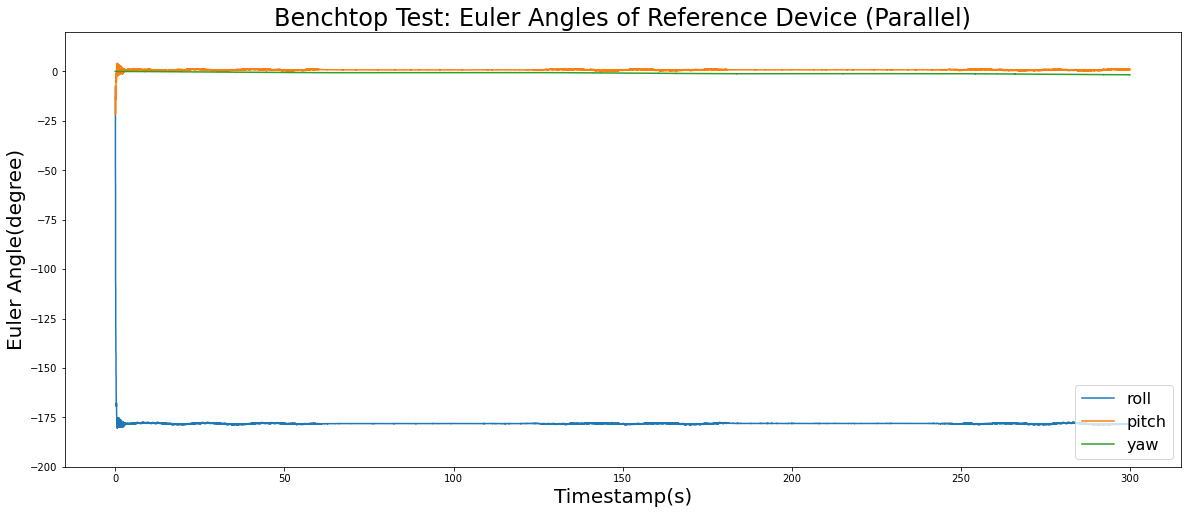

In [173]:
data_plot_G = pd.DataFrame(dat2_ave_final, columns=["Timestamp", "roll", "pitch", "yaw"])
data_plot_G.plot(x="Timestamp", y=["roll", "pitch", "yaw"], figsize=(20, 8))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.legend(fontsize="16", loc ="lower right")
#plt.xlim((0, 600))
plt.ylim((-200, 20))
plt.title("Benchtop Test: Euler Angles of Reference Device (Parallel)", fontsize="24")
plt.savefig('bench_ref_parallel.png')
plt.show()

In [67]:
dat3_ave_final.yaw

0        2.706172e-08
1        2.225417e-07
2        0.000000e+00
3        9.621097e-07
4        0.000000e+00
             ...     
29056   -8.792532e+01
29057   -8.791682e+01
29058   -8.790614e+01
29059   -8.789445e+01
29060   -8.788288e+01
Name: yaw, Length: 29061, dtype: float64

In [565]:
dat3_ave_final.yaw[29025]

90.17688751220703

In [566]:
dat3_ave_final.yaw[0]

2.6763867566614863e-08

In [618]:
dat3_ave_final.Timestamp[29025]

300.112

In [619]:
k = (dat3_ave_final.yaw[29025] - dat3_ave_final.yaw[0])/dat3_ave_final.Timestamp[29025]
k

0.30047744670470744

In [68]:
def linear_drift(x, x0):
    return 1 * (x - x0)

In [69]:
dat3_ave_final.loc[dat3_ave_final.index[0:dat3_ave_final.yaw.size], 'yaw']

0        2.706172e-08
1        2.225417e-07
2        0.000000e+00
3        9.621097e-07
4        0.000000e+00
             ...     
29056   -8.792532e+01
29057   -8.791682e+01
29058   -8.790614e+01
29059   -8.789445e+01
29060   -8.788288e+01
Name: yaw, Length: 29061, dtype: float64

In [572]:
dat3_ave_final.yaw[0:dat3_ave_final.yaw.size].values

array([2.67638676e-08, 3.24164915e-07, 2.19994476e-07, ...,
       9.01581726e+01, 9.01650772e+01, 9.01768875e+01])

In [575]:
dat3_ave_final.Timestamp[0:dat3_ave_final.yaw.size].values.size

29026

In [613]:
dat3_ave_final.loc[dat3_ave_final.index[0:dat3_ave_final.yaw.size], 'yaw']

0        2.676387e-08
1        3.241649e-07
2        2.199945e-07
3       -1.349198e-06
4        9.164489e-07
             ...     
29021    9.015475e+01
29022    9.015632e+01
29023    9.015817e+01
29024    9.016508e+01
29025    9.017689e+01
Name: yaw, Length: 29026, dtype: float64

In [576]:
dat3_ave_final.Timestamp[0:1].values

array([0.])

In [615]:
dat3_ave_final.yaw[0:dat3_ave_final.yaw.size].values

array([2.67638676e-08, 3.24164915e-07, 2.19994476e-07, ...,
       9.01581726e+01, 9.01650772e+01, 9.01768875e+01])

In [53]:
dat3_ave_final.yaw[0:dat3_ave_final.yaw.size].values + linear_drift(dat3_ave_final.Timestamp[0:dat3_ave_final.yaw.size].values, dat3_ave_final.Timestamp[0:1].values)

array([2.70617200e-08, 2.22541715e-07, 0.00000000e+00, ...,
       2.12171864e+02, 2.12183545e+02, 2.12238119e+02])

In [70]:
dat3_ave_final.loc[dat3_ave_final.index[0:dat3_ave_final.yaw.size], 'yaw'] = dat3_ave_final.yaw[0:dat3_ave_final.yaw.size].values - linear_drift(dat3_ave_final.yaw[0:dat3_ave_final.yaw.size].values, dat3_ave_final.yaw[0:1].values)

C:\Users\tongx\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


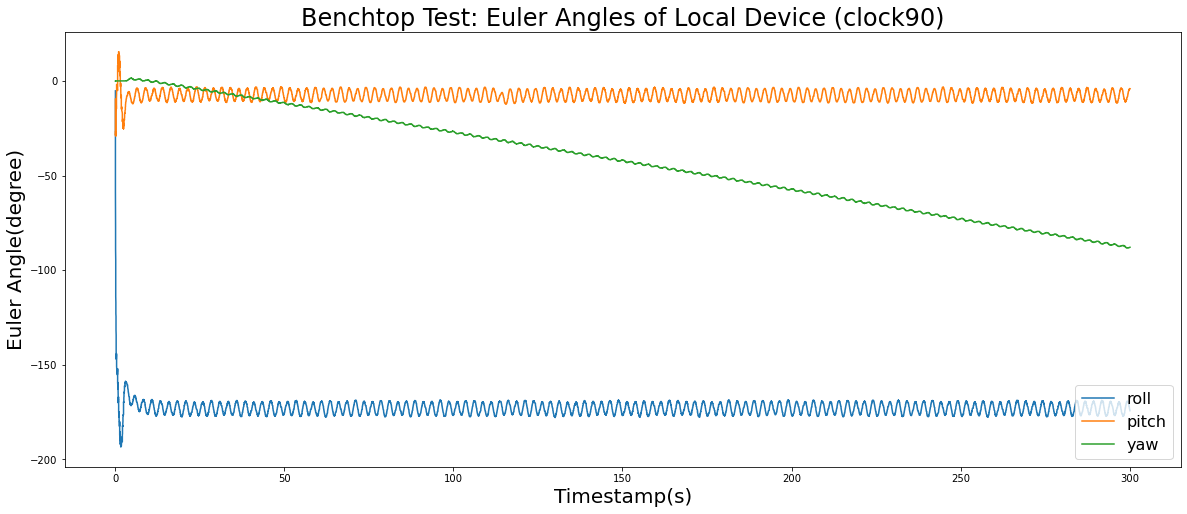

In [174]:
data_plot_G = pd.DataFrame(dat3_ave_final, columns=["Timestamp", "roll", "pitch", "yaw"])
data_plot_G.plot(x="Timestamp", y=["roll", "pitch", "yaw"], figsize=(20, 8))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.legend(fontsize="16", loc ="lower right")
#plt.xlim((0, 600))
#plt.ylim((-200, 100))
plt.title("Benchtop Test: Euler Angles of Local Device (clock90)", fontsize="24")
#plt.savefig('bench_local_neg.png')
plt.show()

In [403]:
def getSTD(timeseries):
    """
    Method to get mean pressure over considered timeframe.

    :param timeseries: (Array) Array containing pressure data from a given time interval (day/stresstest/etc.) for one specific pressure (ABP/ICP/etc.).
    :return: (float) Standard deviation of pressure data.
    """
    return timeseries.std()

In [555]:
w = 600
peak_w = 50
timeseries = dat3_ave_final.pitch.values
time = dat3_ave_final.Timestamp.values

time_w = time[int(w/2):len(time)-int(w/2)]
angle_w = timeseries[int(w/2):len(time)-int(w/2)]

#upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, mov_avg
mov_avg = (np.convolve(timeseries, np.ones(w), 'same') / w)[int(w/2):len(timeseries)-int(w/2)]
timeseries_w = timeseries[int(w/2):len(timeseries)-int(w/2)]
upper_thresh = mov_avg + 2.5*getSTD(mov_avg)
lower_thresh = mov_avg - 2.5*getSTD(mov_avg)

peak_idx, _ = signal.find_peaks(timeseries_w, height=upper_thresh)
valley_idx, _ = signal.find_peaks(-timeseries_w, height=-lower_thresh)

peak_width = signal.peak_widths(timeseries_w, peak_idx)
valley_width = signal.peak_widths(-timeseries_w, valley_idx)
peaks_corrected = peak_idx[np.where(peak_width[0] > peak_w)]
valleys_corrected = valley_idx[np.where(valley_width[0] > peak_w)]
peaks = peaks_corrected
valleys = valleys_corrected

In [556]:
peaks.size

117

In [557]:
peaks_outl_rm = []
valleys_outl_rm = []
for peak in peaks:
    if np.abs(angle_w[peak] - mov_avg[peak]) > 2.5*getSTD(mov_avg):
        peaks_outl_rm.append(peak)
for valley in valleys:
    if np.abs(angle_w[valley] - mov_avg[valley]) > 2.5*getSTD(mov_avg):
        valleys_outl_rm.append(valley)
        
peaks_outl_rm = np.array(peaks_outl_rm)
valleys_outl_rm = np.array(valleys_outl_rm)

In [558]:
piecewise_linear_peaks_outl_rm = np.interp(time_w, time_w[peaks_outl_rm], angle_w[peaks_outl_rm])
piecewise_linear_valleys_outl_rm = np.interp(time_w, time_w[valleys_outl_rm], angle_w[valleys_outl_rm])

In [559]:
peaks.size/(dat3_ave_final.Timestamp.size/104/60)

25.152621787363053

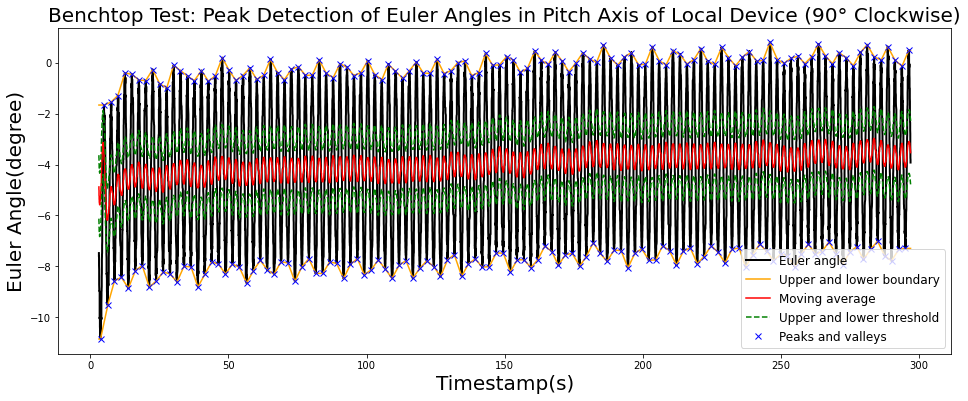

In [562]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
#ax.set_ylabel('Angle(degree)')
#ax.set_xlabel('Time(second)')
a1 = ax.plot(time_w, angle_w, color='black',linewidth=2.0, label = 'Euler angle')
a2 = ax.plot(time_w, piecewise_linear_peaks_outl_rm, color='orange', label = 'Upper and lower boundary')
a3 = ax.plot(time_w, piecewise_linear_valleys_outl_rm, color='orange')
a4 = ax.plot(time_w, mov_avg, color='red', label = 'Moving average')
a5 = ax.plot(time_w, upper_thresh, color='green', linestyle='dashed', label = 'Upper and lower threshold')
a6 = ax.plot(time_w, lower_thresh, color='green', linestyle='dashed')
a7 = ax.plot(time_w[peaks], angle_w[peaks], 'x', color='blue', label = 'Peaks and valleys')
a8 = ax.plot(time_w[valleys], angle_w[valleys], 'x', color='blue')
#ax.legend(loc='upper left')
#plt.xlim(7060,7660)
#plt.ylim((-12, -2))
ax.legend(fontsize="12")
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Benchtop Test: Peak Detection of Euler Angles in Pitch Axis of Local Device (90° Clockwise)", fontsize="20")
plt.savefig('bench_pitch_90pos.png')
plt.show()

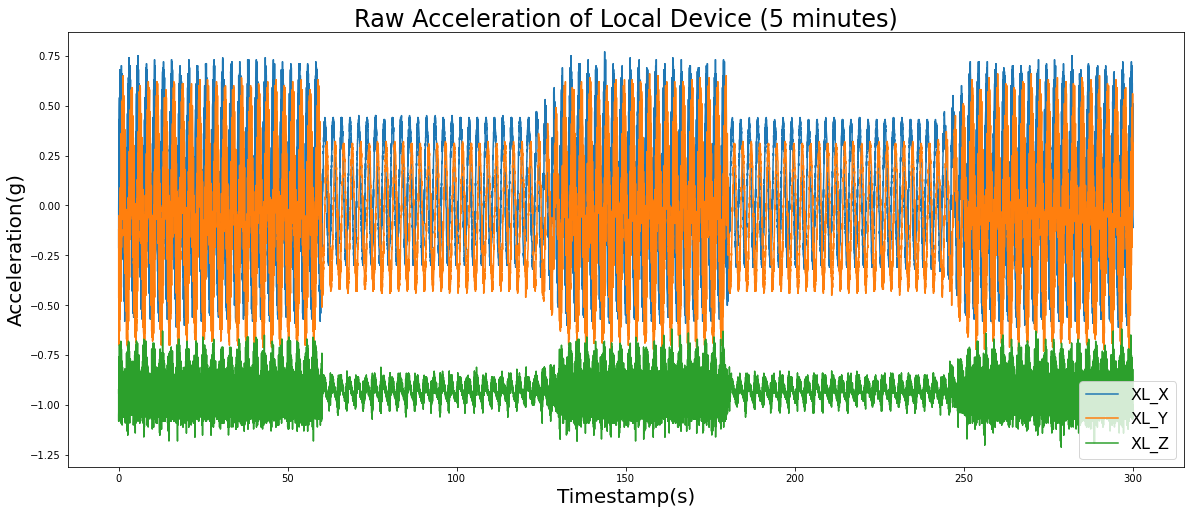

In [718]:
data_plot_G = pd.DataFrame(dat3_ave_final, columns=["Timestamp", "XL_X", "XL_Y", "XL_Z"])
data_plot_G.plot(x="Timestamp", y=["XL_X", "XL_Y", "XL_Z"], figsize=(20, 8))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Acceleration(g)', fontsize="20")
#plt.xlim(620,1220)
#plt.ylim((-1.2, 1.2))
plt.title("Raw Acceleration of Local Device (5 minutes)", fontsize="24")
plt.legend(fontsize="16", loc ="lower right")
plt.savefig('bench_raw_accel_local.png')
plt.show()

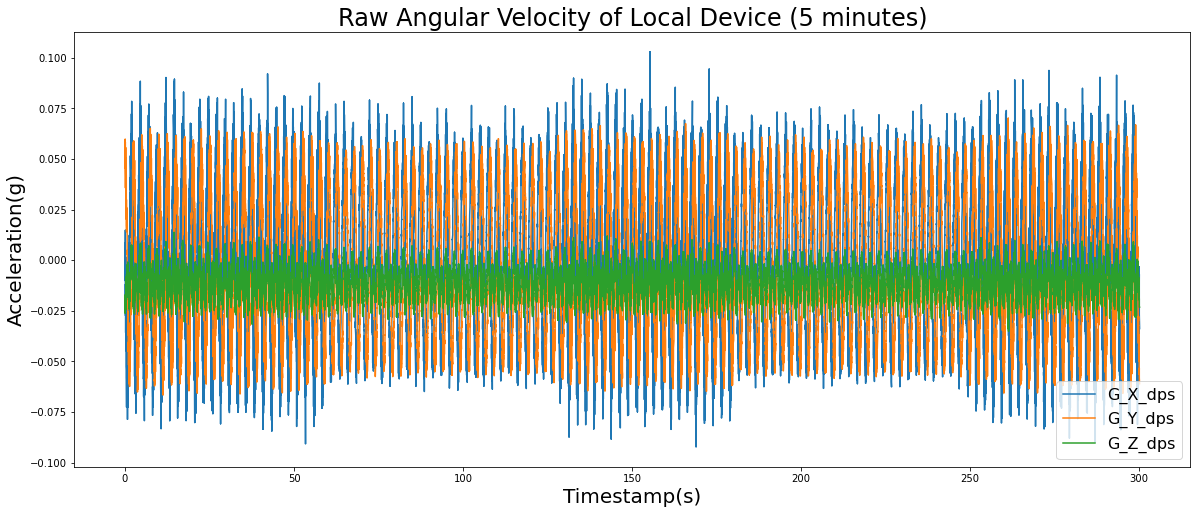

In [719]:
data_plot_G = pd.DataFrame(dat3_ave_final, columns=["Timestamp", "G_X_dps", "G_Y_dps", "G_Z_dps"])
data_plot_G.plot(x="Timestamp", y=["G_X_dps", "G_Y_dps", "G_Z_dps"], figsize=(20, 8))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Acceleration(g)', fontsize="20")
#plt.xlim(620,1220)
#plt.ylim((-1.2, 1.2))
plt.title("Raw Angular Velocity of Local Device (5 minutes)", fontsize="24")
plt.legend(fontsize="16", loc ="lower right")
plt.savefig('bench_raw_angular_local.png')
plt.show()

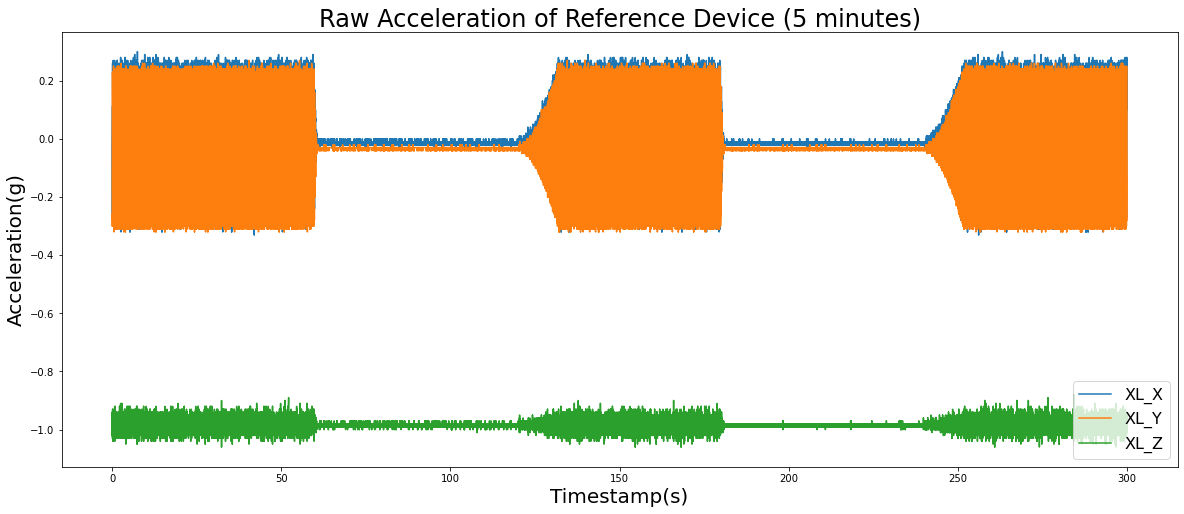

In [720]:
data_plot_G = pd.DataFrame(dat2_ave_final, columns=["Timestamp", "XL_X", "XL_Y", "XL_Z"])
data_plot_G.plot(x="Timestamp", y=["XL_X", "XL_Y", "XL_Z"], figsize=(20, 8))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Acceleration(g)', fontsize="20")
#plt.xlim(620,1220)
#plt.ylim((-1.2, 1.2))
plt.title("Raw Acceleration of Reference Device (5 minutes)", fontsize="24")
plt.legend(fontsize="16", loc ="lower right")
plt.savefig('bench_raw_accel_ref.png')
plt.show()

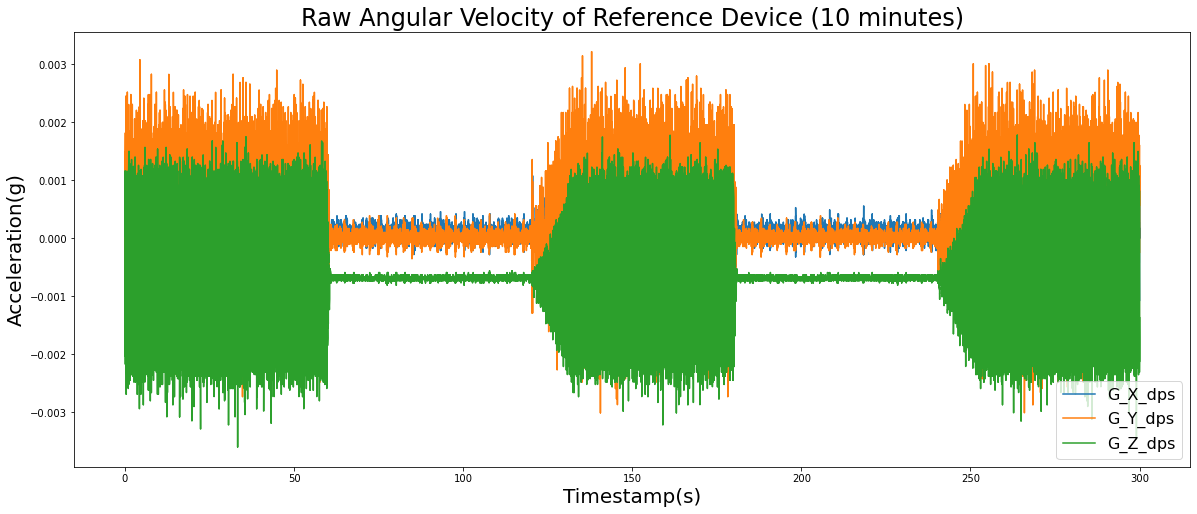

In [721]:
data_plot_G = pd.DataFrame(dat2_ave_final, columns=["Timestamp", "G_X_dps", "G_Y_dps", "G_Z_dps"])
data_plot_G.plot(x="Timestamp", y=["G_X_dps", "G_Y_dps", "G_Z_dps"], figsize=(20, 8))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Acceleration(g)', fontsize="20")
#plt.xlim(620,1220)
#plt.ylim((-1.2, 1.2))
plt.title("Raw Angular Velocity of Reference Device (10 minutes)", fontsize="24")
plt.legend(fontsize="16", loc ="lower right")
plt.savefig('bench_raw_angular_ref.png')
plt.show()

In [168]:
dat3_part = dat3_ave_final.loc[(dat3_ave_final['Timestamp'] >= 1100) & (dat3_ave_final['Timestamp'] <= 1800)]

In [169]:
dat3_part

,Timestamp,XL_X,XL_Y,XL_Z,G_X_dps,G_Y_dps,G_Z_dps,roll,pitch,yaw,G_X_filtered,G_Y_filtered,G_Z_filtered
56964,1192.755,0.26,0.06,0.85,0.00354,0.00542,0.02611,4.761707,-19.992723,7.492374,-0.006827,-0.006992,0.010538
56965,1192.755,0.29,0.07,0.97,0.00182,-0.00970,0.00490,4.758602,-19.976545,7.493479,-0.007166,-0.007499,0.010404
56966,1192.755,0.29,0.07,0.97,0.00472,-0.01442,-0.00266,4.755568,-19.960482,7.494495,-0.007451,-0.007948,0.010202
56967,1192.755,0.29,0.08,0.97,-0.00248,0.00630,-0.00409,4.755357,-19.944235,7.494527,-0.007680,-0.008334,0.009936
56968,1192.787,0.29,0.08,0.97,-0.00017,0.00455,-0.00238,4.755162,-19.928078,7.494574,-0.007849,-0.008653,0.009614
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114014,1785.116,0.20,0.06,1.00,0.00039,0.00004,0.00193,3.949716,-11.123193,10.487888,-0.000013,-0.000142,0.001586
114015,1785.116,0.20,0.06,1.00,0.00042,0.00000,0.00196,3.947237,-11.123999,10.488385,0.000040,-0.000130,0.001709
114016,1785.116,0.20,0.06,1.00,0.00039,0.00004,0.00189,3.944769,-11.124800,10.488880,0.000094,-0.000122,0.001822
114017,1785.116,0.20,0.06,1.00,0.00039,0.00014,0.00185,3.942314,-11.125598,10.489373,0.000148,-0.000117,0.001925


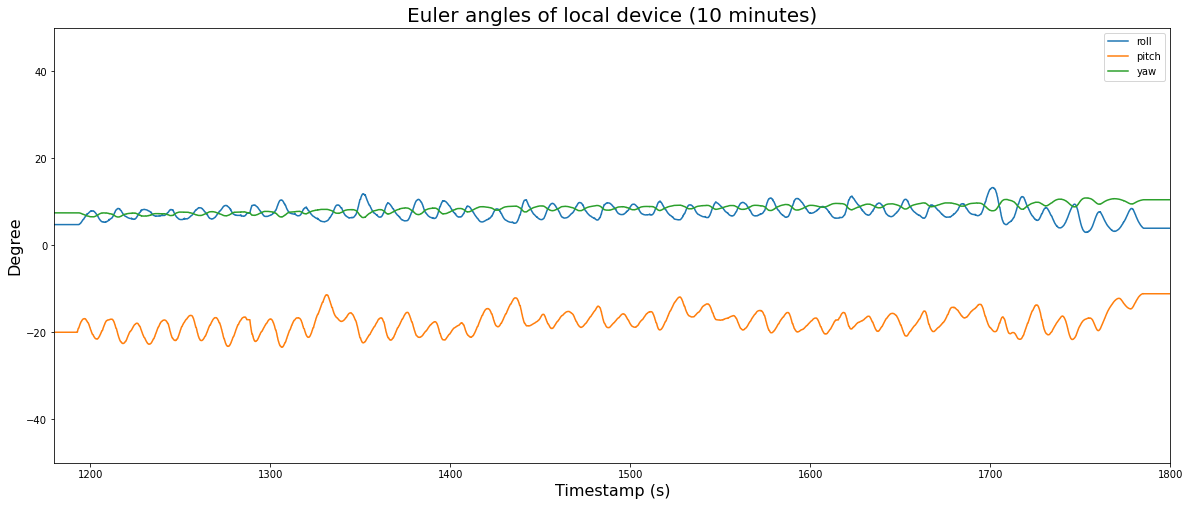

In [156]:
data_plot_G = pd.DataFrame(dat3_ave_final, columns=["Timestamp", "roll", "pitch", "yaw"])
data_plot_G.plot(x="Timestamp", y=["roll", "pitch", "yaw"], figsize=(20, 8))
plt.xlabel('Timestamp (s)', fontsize="16")
plt.ylabel('Degree', fontsize="16")
plt.xlim((1180, 1800))
plt.ylim((-50, 50))
plt.title("Euler angles of local device (10 minutes)", fontsize="20")
plt.show()

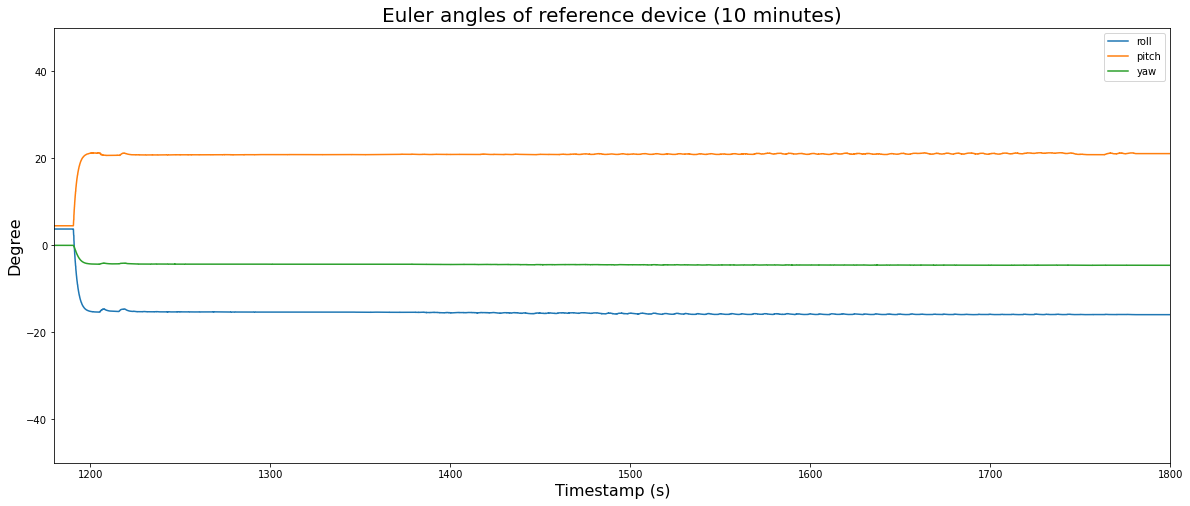

In [157]:
data_plot_G = pd.DataFrame(dat2_ave_final, columns=["Timestamp", "roll", "pitch", "yaw"])
data_plot_G.plot(x="Timestamp", y=["roll", "pitch", "yaw"], figsize=(20, 8))
plt.xlabel('Timestamp (s)', fontsize="16")
plt.ylabel('Degree', fontsize="16")
plt.xlim((1180, 1800))
plt.ylim((-50, 50))
plt.title("Euler angles of reference device (10 minutes)", fontsize="20")
plt.show()

In [171]:
def getSTD(timeseries):
    """
    Method to get mean pressure over considered timeframe.

    :param timeseries: (Array) Array containing pressure data from a given time interval (day/stresstest/etc.) for one specific pressure (ABP/ICP/etc.).
    :return: (float) Standard deviation of pressure data.
    """
    return timeseries.std()

In [198]:
w = 1800
peak_w = 60
timeseries = dat3_part.roll.values
time = dat3_part.Timestamp.values

time_w = time[int(w/2):len(time)-int(w/2)]
angle_w = timeseries[int(w/2):len(time)-int(w/2)]

#upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, mov_avg
mov_avg = (np.convolve(timeseries, np.ones(w), 'same') / w)[int(w/2):len(timeseries)-int(w/2)]
timeseries_w = timeseries[int(w/2):len(timeseries)-int(w/2)]
upper_thresh = mov_avg + getSTD(mov_avg)
lower_thresh = mov_avg - getSTD(mov_avg)

peak_idx, _ = signal.find_peaks(timeseries_w, height=upper_thresh)
valley_idx, _ = signal.find_peaks(-timeseries_w, height=-lower_thresh)

peak_width = signal.peak_widths(timeseries_w, peak_idx)
valley_width = signal.peak_widths(-timeseries_w, valley_idx)
peaks_corrected = peak_idx[np.where(peak_width[0] > peak_w)]
valleys_corrected = valley_idx[np.where(valley_width[0] > peak_w)]
peaks = peaks_corrected
valleys = valleys_corrected

In [199]:
peaks_outl_rm = []
valleys_outl_rm = []
for peak in peaks:
    if np.abs(angle_w[peak] - mov_avg[peak]) > getSTD(mov_avg):
        peaks_outl_rm.append(peak)
for valley in valleys:
    if np.abs(angle_w[valley] - mov_avg[valley]) > 2*getSTD(mov_avg):
        valleys_outl_rm.append(valley)
        
peaks_outl_rm = np.array(peaks_outl_rm)
valleys_outl_rm = np.array(valleys_outl_rm)

In [200]:
#interpolate piecewise linear function between peaks and valleys
piecewise_linear_peaks = np.interp(time_w, time_w[peaks_outl_rm], angle_w[peaks_outl_rm])
piecewise_linear_valleys = np.interp(time_w, time_w[valleys_outl_rm], angle_w[valleys_outl_rm])

mean_pulse_amplitude = (piecewise_linear_peaks-piecewise_linear_valleys).mean()
std_pulse_amplitude = (piecewise_linear_peaks-piecewise_linear_valleys).std()

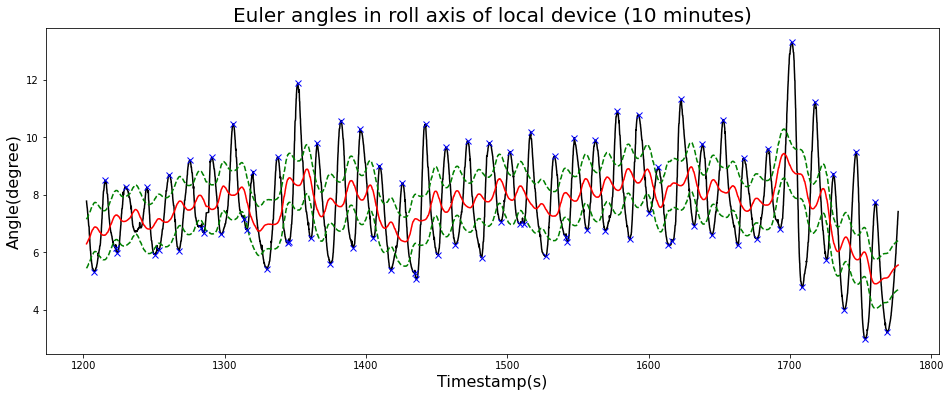

In [201]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
#ax.set_ylabel('Angle(degree)')
#ax.set_xlabel('Time(second)')
ax.plot(time_w, angle_w, color='black')
#ax.plot(time_w, piecewise_linear_peaks_outl_rm, color='blue')
ax.plot(time_w, mov_avg, color='red')
ax.plot(time_w, upper_thresh, color='green', linestyle='dashed')
ax.plot(time_w, lower_thresh, color='green', linestyle='dashed')
ax.plot(time_w[peaks], angle_w[peaks], 'x', color='blue')
ax.plot(time_w[valleys], angle_w[valleys], 'x', color='blue')
#plt.xlim(7060,7650)
#plt.ylim((-12, -2))
plt.xlabel('Timestamp(s)', fontsize="16")
plt.ylabel('Angle(degree)', fontsize="16")
plt.title("Euler angles in roll axis of local device (10 minutes)", fontsize="20")
plt.show()

In [202]:
peaks.size

37

In [197]:
sos = signal.butter(5, 7, 'lp', fs=300, output='sos')
#filtered = sig.sosfilt(sos, dat4["XL_subtract"])

In [152]:
dat2_ave_final["G_X_filtered"] = signal.sosfilt(sos, dat2_ave_final["G_X_dps"])
dat2_ave_final["G_Y_filtered"] = signal.sosfilt(sos, dat2_ave_final["G_Y_dps"])
dat2_ave_final["G_Z_filtered"] = signal.sosfilt(sos, dat2_ave_final["G_Z_dps"])

dat3_ave_final["G_X_filtered"] = signal.sosfilt(sos, dat3_ave_final["G_X_dps"])
dat3_ave_final["G_Y_filtered"] = signal.sosfilt(sos, dat3_ave_final["G_Y_dps"])
dat3_ave_final["G_Z_filtered"] = signal.sosfilt(sos, dat3_ave_final["G_Z_dps"])

<ipython-input-152-fa8fa0b54a0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2_ave_final["G_X_filtered"] = signal.sosfilt(sos, dat2_ave_final["G_X_dps"])
<ipython-input-152-fa8fa0b54a0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat2_ave_final["G_Y_filtered"] = signal.sosfilt(sos, dat2_ave_final["G_Y_dps"])
<ipython-input-152-fa8fa0b54a0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

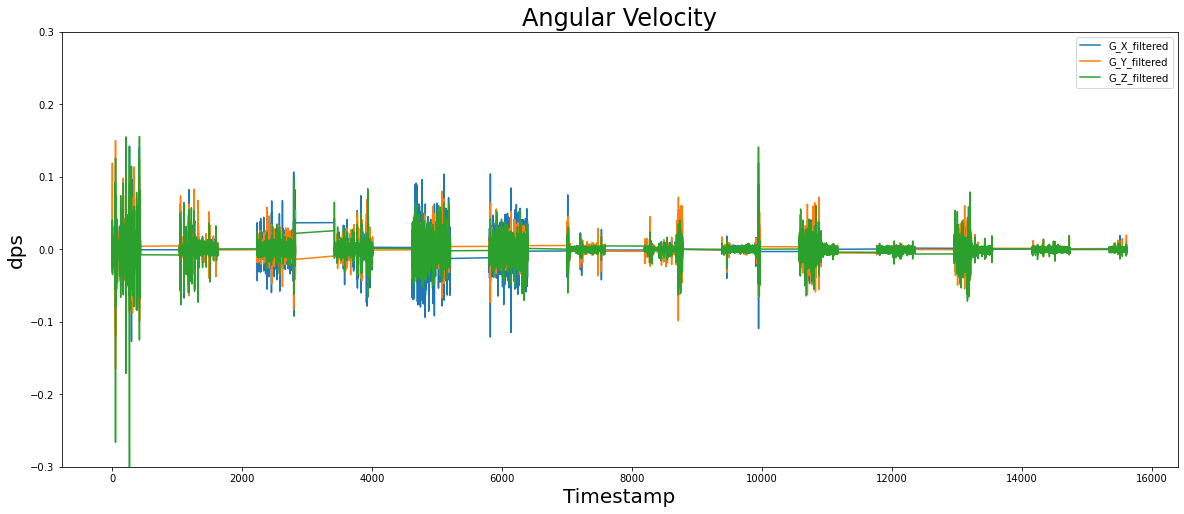

In [40]:
data_plot_G = pd.DataFrame(dat3_ave_final, columns=["Timestamp","G_X_filtered","G_Y_filtered","G_Z_filtered"])
data_plot_G.plot(x="Timestamp", y=["G_X_filtered","G_Y_filtered","G_Z_filtered"], figsize=(20, 8))
plt.xlabel('Timestamp', fontsize="20")
plt.ylabel('dps', fontsize="20")
#plt.xlim((0, 60))
plt.ylim((-0.3, 0.3))
plt.title("Angular Velocity", fontsize="24")
plt.show()

In [41]:
dat3_ave_final['G_X_filtered_ave'] = dat3_ave_final['G_X_filtered'].rolling(60).mean()
dat3_ave_final['G_Y_filtered_ave'] = dat3_ave_final['G_Y_filtered'].rolling(60).mean()
dat3_ave_final['G_Z_filtered_ave'] = dat3_ave_final['G_Z_filtered'].rolling(60).mean()

<ipython-input-41-da199fc04115>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat3_ave_final['G_X_filtered_ave'] = dat3_ave_final['G_X_filtered'].rolling(60).mean()
<ipython-input-41-da199fc04115>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat3_ave_final['G_Y_filtered_ave'] = dat3_ave_final['G_Y_filtered'].rolling(60).mean()
<ipython-input-41-da199fc04115>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [1]:
data_plot_G = pd.DataFrame(dat3_ave_final, columns=["Timestamp","G_X_filtered_ave","G_Y_filtered_ave","G_Z_filtered_ave"])
data_plot_G.plot(x="Timestamp", y=["G_X_filtered_ave","G_Y_filtered_ave","G_Z_filtered_ave"], figsize=(20, 8))
plt.xlabel('Timestamp', fontsize="20")
plt.ylabel('dps', fontsize="20")
#plt.xlim((1000, 1650))
plt.ylim((-0.06, 0.06))
plt.title("Angular Velocity", fontsize="24")
plt.show()

NameError: name 'pd' is not defined

In [ ]:
dat4 = dat2_ave_final.merge(dat3_ave_final, on='Timestamp', indicator=True, how='inner', suffixes=('_bg',  '_mov',)) # dat2: bg

In [ ]:
data_plot_G = pd.DataFrame(dat4, columns=["Timestamp", "G_X_dps_bg", "G_Y_dps_bg", "G_Z_dps_bg"])
data_plot_G.plot(x="Timestamp", y=["G_X_dps_bg", "G_Y_dps_bg", "G_Z_dps_bg"], figsize=(20, 8))
plt.xlabel('Timestamp', fontsize="20")
plt.ylabel('dps', fontsize="20")
plt.xlim((0, 60))
plt.ylim((-0.6, 0.6))
plt.title("Angular Velocity", fontsize="24")
plt.show()

In [ ]:
data_plot_G = pd.DataFrame(dat4, columns=["Timestamp", "G_X_dps_mov", "G_Y_dps_mov", "G_Z_dps_mov"])
data_plot_G.plot(x="Timestamp", y=["G_X_dps_mov", "G_Y_dps_mov", "G_Z_dps_mov"], figsize=(20, 8))
plt.xlabel('Timestamp', fontsize="20")
plt.ylabel('dps', fontsize="20")
plt.xlim((0, 60))
plt.ylim((-0.6, 0.6))
plt.title("Angular Velocity", fontsize="24")
plt.show()

In [ ]:
#dat4["XL_val_diff"] = (dat4["XL_X_diff"]**2 + dat4["XL_Y_diff"]**2 + dat4["XL_Z_diff"]**2)**0.5
dat4["XL_val_bg"] = (dat4["XL_X_bg"]**2 + dat4["XL_Y_bg"]**2 + dat4["XL_Z_bg"]**2)**0.5 - 1
dat4["XL_val_mov"] = (dat4["XL_X_mov"]**2 + dat4["XL_Y_mov"]**2 + dat4["XL_Z_mov"]**2)**0.5 - 1
dat4

In [ ]:
dat4["XL_val_bg_filtered"] = signal.sosfilt(sos, dat4["XL_val_bg"])
dat4["XL_val_mov_filtered"] = signal.sosfilt(sos, dat4["XL_val_mov"])

In [ ]:
dat4["XL_subtract"] = dat4["XL_val_mov_filtered"] - dat4["XL_val_bg_filtered"] #interested for XL
dat4

In [ ]:
dat4['XL_subtract_ave'] = dat4['XL_subtract'].rolling(60).mean()

In [ ]:
data_plot_XL = pd.DataFrame(dat4, columns=["Timestamp", "XL_subtract_ave_inter"])
data_plot_XL.plot(x="Timestamp", y=["XL_subtract_ave_inter"], figsize=(20, 8))
plt.xlabel('Timestamp (s)', fontsize="20")
plt.ylabel('g', fontsize="20")
#plt.xlim((0, 10))
plt.ylim((-4,4))
plt.title("Acceleration", fontsize="24")
plt.show()

In [ ]:
data_plot_XL = pd.DataFrame(dat4, columns=["Timestamp", "XL_val_bg_filtered"])
data_plot_XL.plot(x="Timestamp", y=["XL_val_bg_filtered"], figsize=(20, 8))
plt.xlabel('Timestamp (s)', fontsize="20")
plt.ylabel('g', fontsize="20")
plt.xlim((1530, 1560))
plt.ylim((-0.2,0.2))
plt.title("Acceleration", fontsize="24")
plt.show()

In [ ]:
data_plot_XL = pd.DataFrame(dat4, columns=["Timestamp", "XL_val_mov_filtered"])
data_plot_XL.plot(x="Timestamp", y=["XL_val_mov_filtered"], figsize=(20, 8))
plt.xlabel('Timestamp (s)', fontsize="20")
plt.ylabel('g', fontsize="20")
plt.xlim((1530, 1560))
plt.ylim((-0.2,0.2))
plt.title("Acceleration", fontsize="24")
plt.show()